# Import packages


In [1]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta


# fourier_transfer function

Get a mixed harmonics by n_harm harmonics to fit the date_0 to date_1 stock_name and transfer date_1 to date_2,
df = dataframe


In [2]:
def fourier_transfer(n_harm, stock_name, date_data_start, date_transfer_start, date_transfer_end):
    # get data_stock infomation
    date_data_end = date_transfer_start
    data_stock = yf.Ticker(stock_name).history(
        start=date_data_start, end=date_data_end)['Close']
    array_data = np.array(data_stock)
    n_data = array_data.size
    time_data = np.arange(0, n_data)

    # find linear trend in x
    Polynomial = np.polyfit(time_data, array_data, 1)
    data_notrend = array_data - Polynomial[0] * time_data    # detrended x
    data_freqdom = fft.fft(data_notrend, n=n_data)
    frequence = fft.fftfreq(n_data)
    f_positive = frequence[np.where(frequence > 0)]
    x_freqdom_positive = data_freqdom[np.where(frequence > 0)]
    indexes = list(range(f_positive.size))      # frequencies
    # sort method 1
    # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
    # sort method 2 :
    # sort indexes by amplitudes, lower -> higher
    indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
    indexes.reverse()       # sort indexes by amplitudes, higher -> lower

    data_all = yf.Ticker(stock_name).history(
        start=date_data_start, end=date_transfer_end)
    data_all = data_all['Close']
    time_transfer = np.arange(0, data_all.size)
    restored_sig = np.zeros(time_transfer.size)
    for i in indexes[:n_harm]:
        ampli = np.absolute(x_freqdom_positive[i]) / n_data     # amplitude
        phase = np.angle(x_freqdom_positive[i])      # phase
        signal = ampli * \
            np.cos(2 * np.pi * f_positive[i] * time_transfer + phase)
        restored_sig += signal
    signal = restored_sig
    transferred = pd.DataFrame()
    transferred.index = data_all.index
    transferred['Close'] = signal
    # transferred = transferred[transferred.index > date_transfer_start]
    return transferred


In [3]:
fourier_transfer(20, "^GSPC", '2021-01-01', '2022-01-01', '2022-02-01')


,Close
Date,
2020-12-31,-8.344996
2021-01-04,-15.507935
2021-01-05,-18.908347
2021-01-06,-19.033050
2021-01-07,-17.586088
...,...
2022-01-25,-23.952332
2022-01-26,-28.472736
2022-01-27,-29.377523


# peak_valleys frnction


In [4]:
def peak_valleys(pv_range, data):
    pd.options.mode.chained_assignment = None
    pv = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    peaks = data['peaks']
    valleys = data['valleys']
    for idx in range(0, len(pv)):
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].max():
            peaks.iloc[idx] = pv[idx]
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].min():
            valleys.iloc[idx] = pv[idx]
    return peaks, valleys


In [5]:
# data = yf.Ticker("^GSPC").history(start='2021-01-01', end='2022-01-01')
# pv_range = 2
# peak_valleys(pv_range, data)


In [6]:
def peak_valleys_delay(data, transferred):
    if len(data.index) == len(transferred.index) :
        p_data = pd.DataFrame()
        p_data['peaks_1'] = data['peaks']
        p_data['count'] = range(len(p_data))
        p_data = p_data.drop(p_data[p_data['peaks_1'].isna()].index)
        p_data_list = list(p_data['count'])
        p_transferred = pd.DataFrame()
        p_transferred['peaks_2'] = transferred['peaks']
        p_transferred['count'] = range(len(p_transferred))
        p_transferred = p_transferred.drop(p_transferred[p_transferred['peaks_2'].isna()].index)
        p_transferred_list = list(p_transferred['count'])
        li_peak = []
        for i in range(0, len(p_transferred_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_list)):
                temp.append((p_data_list[j] - p_transferred_list[i]))
                temp_abs.append(abs(p_data_list[j] - p_transferred_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            li_peak.append(temp_2)
        p_transferred['delay'] = li_peak

        v_data = pd.DataFrame()
        v_data['valleys_1'] = data['valleys']
        v_data['count'] = range(len(v_data))
        v_data = v_data.drop(v_data[v_data['valleys_1'].isna()].index)
        v_data_list = list(v_data['count'])
        v_transferred = pd.DataFrame()
        v_transferred['valleys_2'] = transferred['valleys']
        v_transferred['count'] = range(len(v_transferred))
        v_transferred = v_transferred.drop(v_transferred[v_transferred['valleys_2'].isna()].index)
        v_transferred_list = list(v_transferred['count'])
        li_valley = []
        for i in range(0, len(v_transferred_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_list)):
                temp.append((v_data_list[j] - v_transferred_list[i]))
                temp_abs.append(abs(v_data_list[j] - v_transferred_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            li_valley.append(temp_2)
        v_transferred['delay'] = li_valley
        return p_transferred['delay'], v_transferred['delay']
    else:
        print(len(data.index), len(transferred.index))


In [7]:
data = yf.Ticker("^GSPC").history(start='2021-01-01', end='2021-01-30')
data2 = fourier_transfer(20, "^GSPC", '2021-01-01', '2021-01-15', '2021-01-30')
pv_range = 2
data2['peaks'] = peak_valleys(pv_range, data2)[0]
data2['valleys'] = peak_valleys(pv_range, data2)[1]
data['peaks'] = peak_valleys(pv_range, data)[0]
data['valleys'] = peak_valleys(pv_range, data)[1]
data2['peaks_delay'] = peak_valleys_delay(data, data2)[0]
data2['valleys_delay'] = peak_valleys_delay(data, data2)[1]
print(data)
print(data2)


                   Open         High          Low        Close      Volume  \
Date                                                                         
2020-12-31  3733.270020  3760.199951  3726.879883  3756.070068  3179040000   
2021-01-04  3764.610107  3769.989990  3662.709961  3700.649902  5015000000   
2021-01-05  3698.020020  3737.830078  3695.070068  3726.860107  4591020000   
2021-01-06  3712.199951  3783.040039  3705.340088  3748.139893  6064110000   
2021-01-07  3764.709961  3811.550049  3764.709961  3803.790039  5099160000   
2021-01-08  3815.050049  3826.689941  3783.600098  3824.679932  4773040000   
2021-01-11  3803.139893  3817.860107  3789.020020  3799.610107  4465430000   
2021-01-12  3801.620117  3810.780029  3776.510010  3801.189941  4994950000   
2021-01-13  3802.229980  3820.959961  3791.500000  3809.840088  4602510000   
2021-01-14  3814.979980  3823.600098  3792.860107  3795.540039  5198480000   
2021-01-15  3788.729980  3788.729980  3749.620117  3768.250000  

In [8]:
def draw_plot_1(data, transferred):
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    axes[0].plot(data.index, data['Close'],
                 c='gray', label='data', linewidth=3)
    axes[1].plot(transferred.index, transferred['Close'], c='gray', label='Predict', linewidth=3)
    try:
        axes[0].plot(data.index, data['peaks'], '^',
                     c='royalblue', label='peaks')
        axes[0].plot(data.index, data['valleys'], 'v',
                     c='orangered', label='valleys')
        axes[1].plot(transferred.index, transferred['peaks'], '^', c='royalblue', label='peaks')
        axes[1].plot(transferred.index, transferred['valleys'], 'v',
                     c='orangered', label='valleys')
    except:
        pass
    try:
        for i, label in enumerate(transferred['peaks_delay']):
            axes[1].annotate(label, (transferred['peaks'].index[i],
                             transferred['peaks'][i]), fontsize=14)
        for i, label in enumerate(transferred['valleys_delay']):
            axes[1].annotate(label, (transferred['valleys'].index[i],
                             transferred['valleys'][i]), fontsize=14)
    except:
        pass
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("amplitude", fontsize=14)
    axes[0].legend()
    axes[1].legend()
    plt.show()
    return


# error function

三種 type 計算 fit_error，得 error_p,error_v。
fit_error 為 error_p 及 error_v 取平均。
best_fit 為取最接近零的 error 之 harmonic。
slide_error 為預測之第一個轉折 delay。
final_error 為 slide_error 取絕對值後取平均。


In [9]:
def fit_error(transferred, fit_method):
    temp_p = transferred.drop(
        transferred[transferred['peaks_delay'].isna()].index)
    temp_v = transferred.drop(
        transferred[transferred['valleys_delay'].isna()].index)
    if fit_method == 'mean':
        error_p = temp_p['peaks_delay'].mean()
        error_v = temp_v['valleys_delay'].mean()
    elif fit_method == 'abs':
        error_p = abs(transferred['peaks_delay']).mean()
        error_v = abs(transferred['valleys_delay']).mean()
    else:
        return 'wrong fit_method'
    error = (error_p + error_v)/2
    return error


In [10]:
# data = yf.Ticker("^GSPC").history(start='2020-01-01', end='2021-02-01')
# data2 = fourier_transfer(19, "^GSPC", '2020-01-01', '2021-01-01', '2021-02-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range, data2)[0]
# data2['valleys'] = peak_valleys(pv_range, data2)[1]
# data['peaks'] = peak_valleys(pv_range, data)[0]
# data['valleys'] = peak_valleys(pv_range, data)[1]
# data2['peaks_delay'] = peak_valleys_delay(
#     data[data.index <= '2021-01-01'], data2[data2.index <= '2021-01-01'])[0]
# data2['valleys_delay'] = peak_valleys_delay(
#     data[data.index <= '2021-01-01'], data2[data2.index <= '2021-01-01'])[1]
# print('abs =', fit_error(data2, 'abs'))
# print('mean =', fit_error(data2, 'mean'))
# print('positive =', fit_error(data2, 'positive'))


In [11]:
# data2['peaks_delay'] = peak_valleys_delay(data, data2)[0]
# data2['valleys_delay'] = peak_valleys_delay(data, data2)[1]
# draw_plot_1(data, data2)


In [12]:
def get_first_delay(transferred):
    temp = pd.DataFrame()
    temp['peaks_delay'] = transferred['peaks_delay']
    temp['valleys_delay'] = transferred['valleys_delay']
    temp = temp.dropna(how='all')
    if np.isnan(temp['peaks_delay'].iloc[0]) == False:
        Date = temp['peaks_delay'].index[0]
        delay = temp['peaks_delay'].iloc[0]
        pv = 'peaks'
    else:
        Date = temp['valleys_delay'].index[0]
        delay = temp['valleys_delay'].iloc[0]
        pv = 'valleys'
    # Date = datetime.datetime.strftime(Date, '%Y-%m-%d')
    return Date, delay, pv


In [13]:
# data = yf.Ticker("^GSPC").history(start='2020-01-01', end='2021-01-01')
# data2 = fourier_transfer(20, "^GSPC", '2020-01-01', '2021-01-01', '2021-02-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range, data2)[0]
# data2['valleys'] = peak_valleys(pv_range, data2)[1]
# data['peaks'] = peak_valleys(pv_range, data)[0]
# data['valleys'] = peak_valleys(pv_range, data)[1]
# data2['peaks_delay'] = peak_valleys_delay(
#     data[data.index <= '2021-01-01'], data2[data2.index <= '2021-01-01'])[0]
# data2['valleys_delay'] = peak_valleys_delay(
#     data[data.index <= '2021-01-01'], data2[data2.index <= '2021-01-01'])[1]
# get_first_delay(data2)


In [14]:
def single_task(stock_name, date_0, date_1, date_2, n_harm, pv_range, fit_method):
    data = yf.Ticker(stock_name).history(start=date_0, end=date_2)
    data['peaks'] = peak_valleys(pv_range, data)[0]
    data['valleys'] = peak_valleys(pv_range, data)[1]
    transerred = fourier_transfer(n_harm, stock_name, date_0, date_1, date_2)
    transerred['peaks'] = peak_valleys(pv_range, transerred)[0]
    transerred['valleys'] = peak_valleys(pv_range, transerred)[1]
    transerred['peaks_delay'] = peak_valleys_delay(
        data[data.index <= date_1], transerred[transerred.index <= date_1])[0]
    transerred['valleys_delay'] = peak_valleys_delay(
        data[data.index <= date_1], transerred[transerred.index <= date_1])[1]
    error = fit_error(transerred, fit_method)
    transerred['peaks_delay'] = peak_valleys_delay(data, transerred)[0]
    transerred['valleys_delay'] = peak_valleys_delay(data, transerred)[1]
    return data, transerred, error


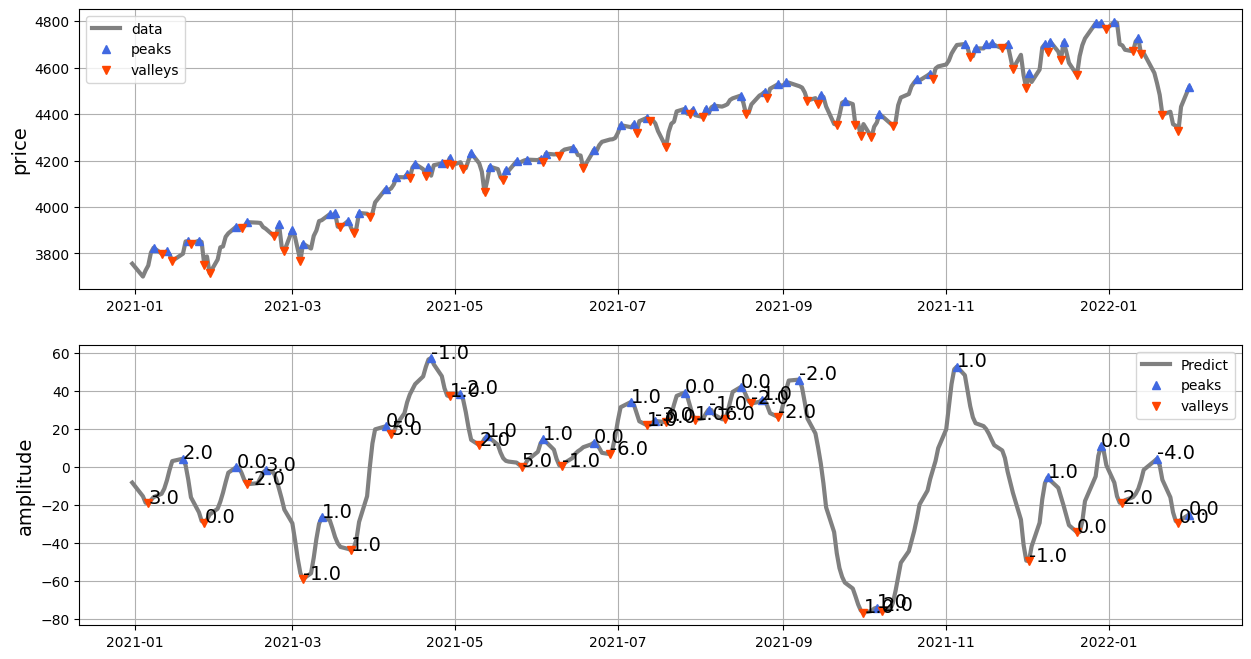

1.5476190476190474


In [15]:
a = single_task("^GSPC", '2021-01-01', '2022-01-01',
                    '2022-02-01', 20, 2, 'abs')
data = a[0]
df = a[1]
error = a[2]
draw_plot_1(data, df)
print(error)


In [16]:
# def main_function_slide(stock_name, date_start, data_range, transfer_range, n_harm, pv_range, n_slide):
#     date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
#     date_0 = date_start + relativedelta(months=-data_range)
#     transerred = pd.DataFrame()
#     data = pd.DataFrame()
#     fig, axes = plt.subplots(2, 1, figsize=(15, 8))
#     for i in range(n_slide):
#         date_1 = date_0 + relativedelta(months=+data_range)
#         date_2 = date_1 + relativedelta(months=+transfer_range)
#         temp = fourier_transfer(n_harm, stock_name, date_0, date_1, date_2)
#         temp = temp.drop(temp[temp.index < date_1].index)
#         axes[1].plot(temp.index, temp['Close'], label='Predict', linewidth=3)
#         temp['peaks'] = peak_valleys(pv_range, temp)[0]
#         temp['valleys'] = peak_valleys(pv_range, temp)[1]
#         data_temp = yf.Ticker(stock_name).history(start=date_1, end=date_2)
#         axes[0].plot(data_temp.index, data_temp['Close'],
#                      linewidth=3, label='Test_data')
#         data_temp['peaks'] = peak_valleys(pv_range, data_temp)[0]
#         data_temp['valleys'] = peak_valleys(pv_range, data_temp)[1]
#         temp['peaks_delay'] = peak_valleys_delay(data_temp, temp)[0]
#         temp['valleys_delay'] = peak_valleys_delay(data_temp, temp)[1]
#         axes[0].plot(data_temp.index, data_temp['peaks'],
#                      '^', c='royalblue', label='peaks')
#         axes[0].plot(data_temp.index, data_temp['valleys'],
#                      'v', c='orangered', label='valleys')
#         axes[1].plot(temp.index, temp['peaks'], '^',
#                      c='royalblue', label='peaks')
#         axes[1].plot(temp.index, temp['valleys'], 'v',
#                      c='orangered', label='valleys')
#         transerred = pd.concat([df, temp])
#         data = pd.concat([data, data_temp])
#         date_0 = date_0 + relativedelta(months=+1)
#     for i, label in enumerate(df['peaks_delay']):
#         axes[1].annotate(label, (df['peaks'].index[i],
#                          df['peaks'][i]), fontsize=14)
#     for i, label in enumerate(df['valleys_delay']):
#         axes[1].annotate(label, (df['valleys'].index[i],
#                          df['valleys'][i]), fontsize=14)
#     axes[0].set_ylabel("price", fontsize=14)
#     axes[0].grid(True)
#     axes[1].grid(True)
#     axes[1].set_ylabel("amplitude", fontsize=14)
#     plt.show()
#     return data, df


In [17]:
# a = main_function_slide("^GSPC", '2021-01-01', 12, 1, 20, 2, 12)
# data = a[0]
# df = a[1]
# print('abs =', fit_error(df, 'abs'))
# print('positive =', fit_error(df, 'positive'))
# print('mean =', fit_error(df, 'mean'))


In [18]:
def fit_error_task(stock_name, date_0, date_1, date_2, n_harm_0, n_harm_1, pv_range, fit_method):
    error = pd.Series(dtype='float64')
    for i in range(n_harm_0, n_harm_1+1):
        temp = single_task(stock_name, date_0, date_1,
                               date_2, i, pv_range, fit_method)
        error = pd.concat([error, pd.Series(temp[2])])
    error = error.reset_index(drop=True)
    error = error.abs()
    best_fit = error.idxmin() + n_harm_0
    temp_2 = single_task(stock_name, date_0, date_1,
                             date_2, best_fit, pv_range, fit_method)
    data, transerred, error = temp_2
    return data, transerred, error, best_fit


In [19]:
a = fit_error_task(
    "^GSPC", '2021-06-01', '2022-07-01', '2022-02-01', 15, 17, 2, 'mean')
a


(                   Open         High          Low        Close      Volume  \
 Date                                                                         
 2021-06-01  4216.520020  4234.120117  4197.589844  4202.040039  5074670000   
 2021-06-02  4206.819824  4217.370117  4198.270020  4208.120117  5833670000   
 2021-06-03  4191.430176  4204.390137  4167.930176  4192.850098  5587970000   
 2021-06-04  4206.049805  4233.450195  4206.049805  4229.890137  4139790000   
 2021-06-07  4229.339844  4232.339844  4215.660156  4226.520020  4476920000   
 ...                 ...          ...          ...          ...         ...   
 2022-01-25  4366.640137  4411.009766  4287.109863  4356.450195  5145050000   
 2022-01-26  4408.430176  4453.229980  4304.799805  4349.930176  5570640000   
 2022-01-27  4380.580078  4428.740234  4309.500000  4326.509766  5214200000   
 2022-01-28  4336.189941  4432.720215  4292.459961  4431.850098  5031090000   
 2022-01-31  4431.790039  4516.890137  4414.020020  

In [20]:
# def main_function_slide_fit_error(stock_name, date_start, data_range, transfer_range, n_harm_0, n_harm_1, pv_range, n_slide, fit_method):
#     date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
#     date_0 = date_start + relativedelta(months=-data_range)
#     df = pd.DataFrame()
#     data = pd.DataFrame()
#     fit_error = []
#     best_fit = []
#     slide_error = []
#     fig, axes = plt.subplots(2, 1, figsize=(15, 8))
#     for i in range(n_slide):
#         date_1 = date_0 + relativedelta(months=+data_range)
#         date_2 = date_1 + relativedelta(months=+transfer_range)
#         data_drop, temp, error_temp, best_fit_temp = fit_error_task(
#             stock_name, date_0, date_1, date_2, n_harm_0, n_harm_1, 2, fit_method)
#         fit_error.append(round(error_temp, 2))
#         best_fit.append(best_fit_temp)
#         temp = temp.drop(temp[temp.index < date_1].index)
#         axes[1].plot(temp.index, temp['Close'], label='Predict', linewidth=3)
#         temp['peaks'] = peak_valleys(pv_range, temp)[0]
#         temp['valleys'] = peak_valleys(pv_range, temp)[1]
#         data_temp = yf.Ticker(stock_name).history(start=date_1, end=date_2)
#         axes[0].plot(data_temp.index, data_temp['Close'],
#                      linewidth=3, label='Test_data')
#         data_temp['peaks'] = peak_valleys(pv_range, data_temp)[0]
#         data_temp['valleys'] = peak_valleys(pv_range, data_temp)[1]
#         temp['peaks_delay'] = peak_valleys_delay(data_temp, temp)[0]
#         temp['valleys_delay'] = peak_valleys_delay(data_temp, temp)[1]
#         df_temp_error = pd.concat([temp['peaks_delay'], temp['valleys_delay']])
#         try:
#             slide_error.append(df_temp_error.dropna()[0])
#         except:
#             pass
#         axes[0].plot(data_temp.index, data_temp['peaks'],
#                      '^', c='royalblue', label='peaks')
#         axes[0].plot(data_temp.index, data_temp['valleys'],
#                      'v', c='orangered', label='valleys')
#         axes[1].plot(temp.index, temp['peaks'], '^',
#                      c='royalblue', label='peaks')
#         axes[1].plot(temp.index, temp['valleys'], 'v',
#                      c='orangered', label='valleys')
#         df = pd.concat([df, temp])
#         data = pd.concat([data, data_temp])
#         date_0 = date_0 + relativedelta(months=+transfer_range)
#     for i, label in enumerate(df['peaks_delay']):
#         axes[1].annotate(label, (df['peaks'].index[i],
#                          df['peaks'][i]), fontsize=14)
#     for i, label in enumerate(df['valleys_delay']):
#         axes[1].annotate(label, (df['valleys'].index[i],
#                          df['valleys'][i]), fontsize=14)
#     axes[0].set_ylabel("price", fontsize=14)
#     axes[0].grid(True)
#     axes[1].grid(True)
#     axes[1].set_ylabel("amplitude", fontsize=14)
#     final_error = round(sum([abs(ele)
#                         for ele in slide_error]) / len(slide_error), 2)
#     plt.show()
#     return data, df, fit_error, best_fit, final_error


In [21]:
# slide_mean = main_function_slide_fit_error(
#     "^GSPC", '2021-01-01', 12, 1, 10, 11, 2, 1, 'mean')
# print(slide_mean[2])
# print(slide_mean[3])
# print(slide_mean[4])


In [22]:
def main_function_slide_fit_error_slide_range(stock_name, date_start, data_range, slide_range, n_slide, pv_range, n_harm_0, n_harm_1, fit_method):
    transfer_range = data_range
    date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
    date_0 = date_start + relativedelta(months=-data_range)
    df = pd.DataFrame()
    data = pd.DataFrame()
    fit_error = []
    best_fit = []
    df_delay = pd.DataFrame(columns=['Start_Date', 'Target_Date', 'delay', 'pv'])
    for i in range(n_slide):
        date_1 = date_0 + relativedelta(months=+data_range)
        date_2 = date_1 + relativedelta(months=+transfer_range)
        data_drop, temp, error_temp, best_fit_temp = fit_error_task(
            stock_name, date_0, date_1, date_2, n_harm_0, n_harm_1, pv_range, fit_method)
        fit_error.append(round(error_temp, 2))
        best_fit.append(best_fit_temp)
        temp = temp.drop(temp[temp.index < date_1].index)
        temp = temp.drop(columns='Close')
        df_delay.loc[i, 'Start_Date'] = date_1
        df_delay.loc[i, 'Target_Date'], df_delay.loc[i,'delay'], df_delay.loc[i, 'pv'] = get_first_delay(temp)
        df = pd.concat([df[df.index < temp.index[0]], temp])
        date_0 = date_0 + relativedelta(weeks=+slide_range)
    data = yf.Ticker(stock_name).history(start=date_start, end=date_2)
    data['peaks'] = peak_valleys(pv_range, data)[0]
    data['valleys'] = peak_valleys(pv_range, data)[1]
    df_delay = df_delay.set_index(df_delay['Target_Date'], drop=False)
    final_error = round(
        sum([abs(ele) for ele in df_delay['delay']]) / len(df_delay['delay']), 2)
    df_delay = df_delay.set_index(df_delay['Start_Date'])
    df_delay = df_delay.drop(columns='Start_Date')
    df_delay['fit_error'] = fit_error
    df_delay['best_fit'] = best_fit

    return final_error, df_delay


In [23]:
slide_abs_test = main_function_slide_fit_error_slide_range(
    stock_name="^GSPC", date_start='2021-01-01', data_range=6,
    slide_range=2, n_slide=4, pv_range=2, n_harm_0=20, n_harm_1=20, fit_method='abs'
)
print(slide_abs_test[0])
print(slide_abs_test[1])

1.0
                    Target_Date delay       pv  fit_error  best_fit
Start_Date                                                         
2021-01-01  2021-01-06 00:00:00  -2.0  valleys       1.56        20
2021-01-15  2021-01-22 00:00:00   0.0  valleys       1.18        20
2021-01-29  2021-02-01 00:00:00  -1.0  valleys       0.83        20
2021-02-12  2021-02-16 00:00:00  -1.0    peaks       1.05        20


In [24]:
slide_mean_test = main_function_slide_fit_error_slide_range(
    stock_name="^GSPC", date_start='2021-01-01', data_range=6,
    slide_range=2, n_slide=24, pv_range=2, n_harm_0=20, n_harm_1=20, fit_method='mean'
)
print(slide_mean_test[0])
print(slide_mean_test[1])


1.38
                    Target_Date delay       pv  fit_error  best_fit
Start_Date                                                         
2021-01-01  2021-01-06 00:00:00  -2.0  valleys       0.55        20
2021-01-15  2021-01-22 00:00:00   0.0  valleys       0.42        20
2021-01-29  2021-02-01 00:00:00  -1.0  valleys      -0.25        20
2021-02-12  2021-02-16 00:00:00  -1.0    peaks       0.14        20
2021-02-26  2021-03-05 00:00:00   0.0    peaks      -0.14        20
2021-03-09  2021-03-15 00:00:00   0.0    peaks      -0.02        20
2021-03-23  2021-03-23 00:00:00   1.0  valleys      -0.04        20
2021-04-07  2021-04-07 00:00:00   5.0  valleys      -0.46        20
2021-04-21  2021-05-03 00:00:00   1.0  valleys       0.02        20
2021-05-04  2021-05-05 00:00:00  -1.0  valleys       0.12        20
2021-05-18  2021-05-18 00:00:00   2.0    peaks      -0.03        20
2021-06-02  2021-06-07 00:00:00  -1.0    peaks      -0.29        20
2021-06-16  2021-06-18 00:00:00   2.0    pe

6


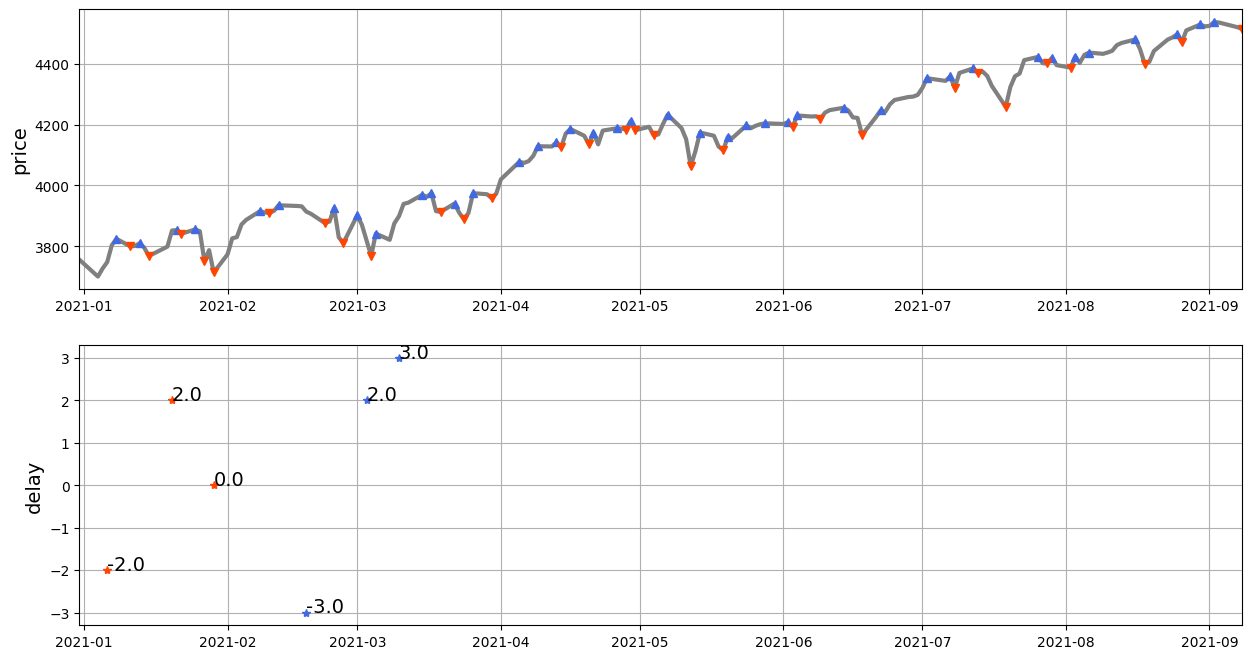

[0.27, -0.03, 0.15, 0.0, 0.02, 0.0]
[33, 36, 39, 24, 39, 36]
2.0
                           Date delay       pv
Start                                         
2021-01-01  2021-01-06 00:00:00  -2.0  valleys
2021-01-15  2021-01-20 00:00:00   2.0  valleys
2021-01-29  2021-01-29 00:00:00   0.0  valleys
2021-02-12  2021-02-18 00:00:00  -3.0    peaks
2021-02-26  2021-03-03 00:00:00   2.0    peaks
2021-03-09  2021-03-10 00:00:00   3.0    peaks


In [77]:
slide_mean_test = main_function_slide_fit_error_slide_range(
    stock_name="^GSPC", date_start='2021-01-01', data_range=6,
    slide_range=2, n_slide=6, pv_range=2, n_harm_0=20, n_harm_1=40, fit_method='mean'
)
print(slide_mean_test[2])
print(slide_mean_test[3])
print(slide_mean_test[4])
print(slide_mean_test[5])
